# Asymmetric transit model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
import lightkurve as lk

## Read K1255 lightcurve

In [11]:
k1255_df = pd.read_csv('k1255_lc.dat', delim_whitespace=True, header=None,
                       names=['t', 'flux', 'flux_err'])

In [16]:
k1255_lc = lk.LightCurve(time=k1255_df.t, flux=k1255_lc.flux, flux_err=k1255_lc.flux_err).remove_outliers()

In [20]:
k1255_lc_binned = k1255_lc.bin(time_bin_size=1/60.)

In [375]:
k1255_lc_short = k1255_lc[22000:31500]

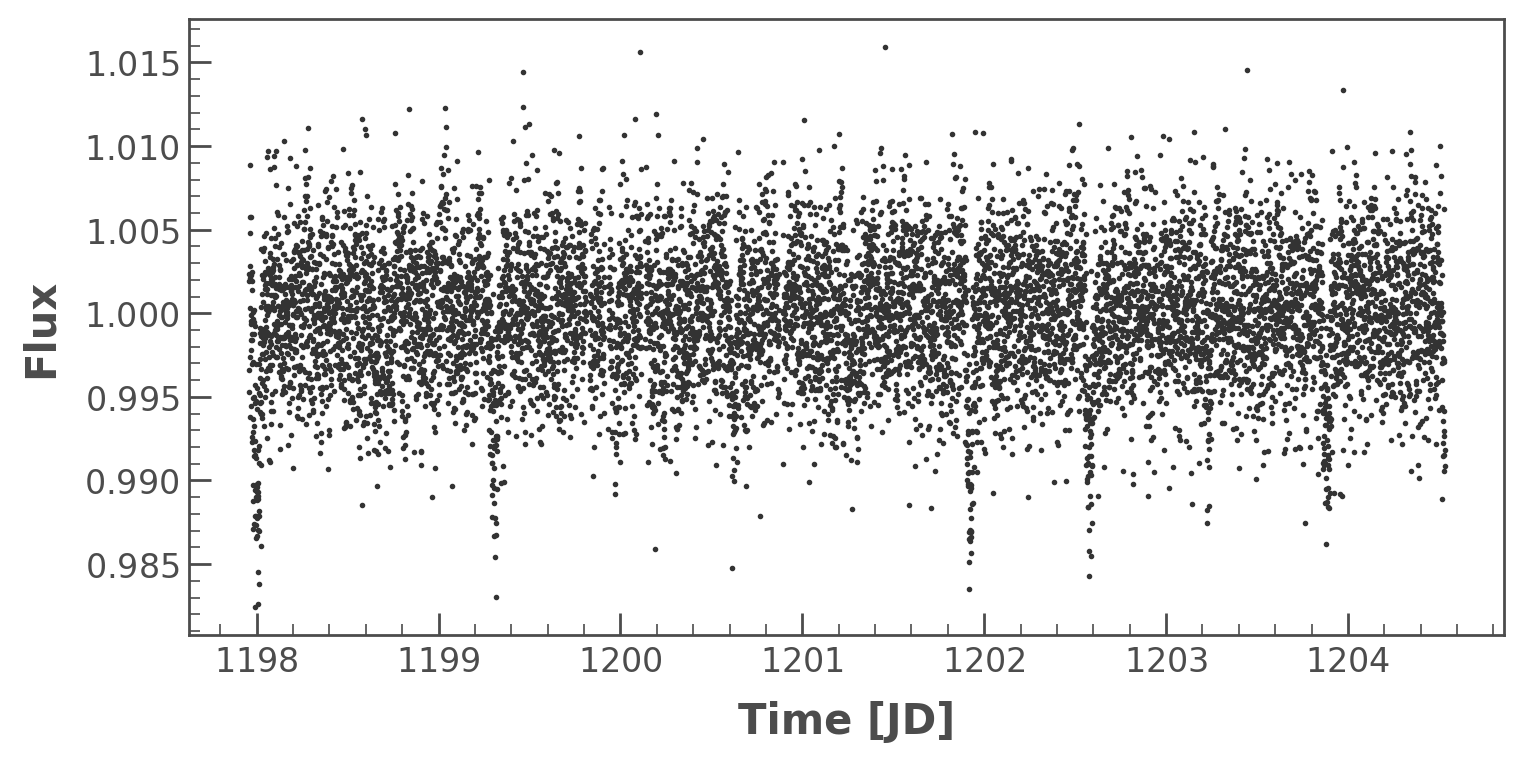

In [376]:
k1255_lc_short.scatter();

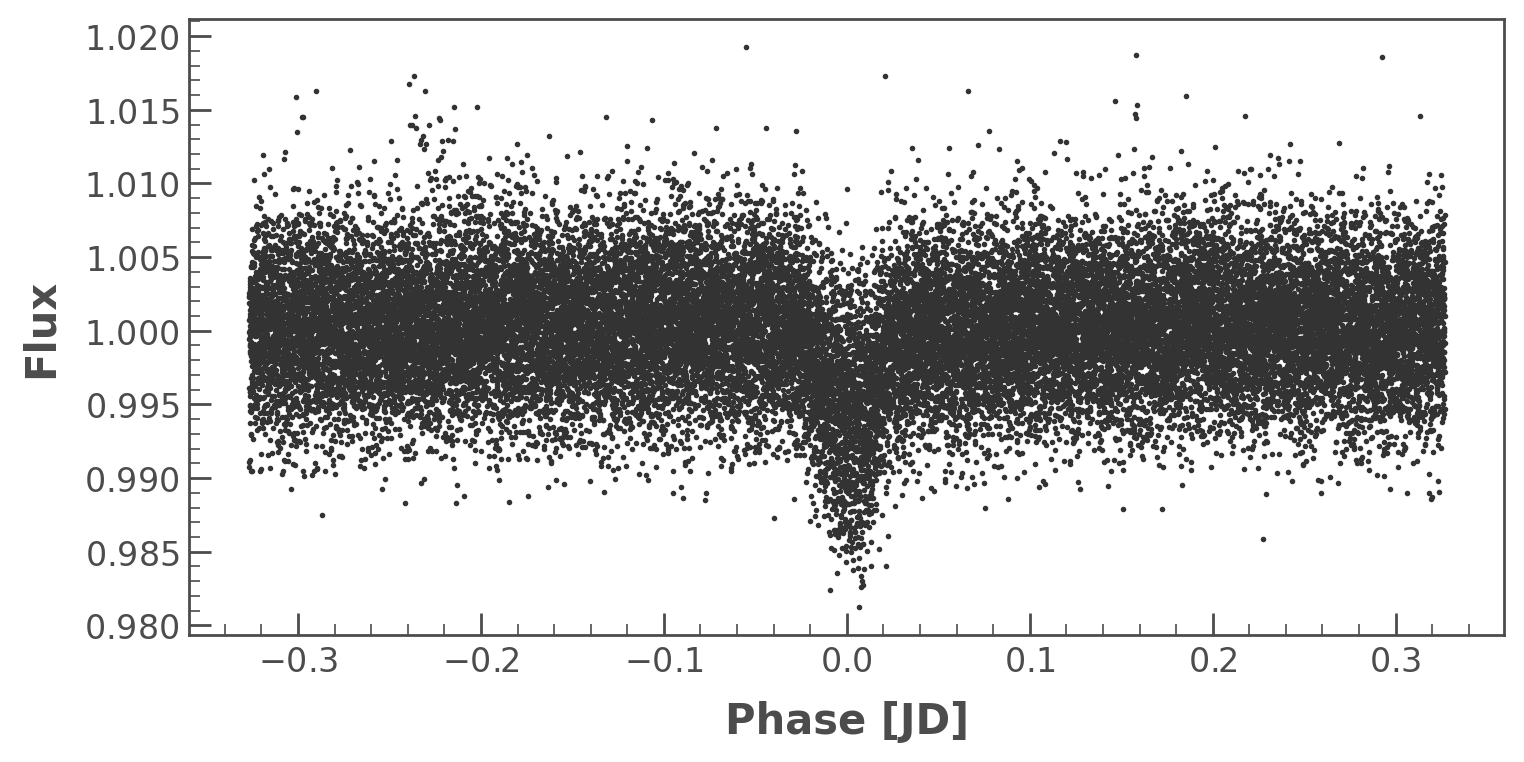

In [121]:
k1255_lc_folded = k1255_lc_short.fold(period=15.685/24.0, normalize_phase=False, epoch_time=1182.97)
ax = k1255_lc_folded.scatter()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

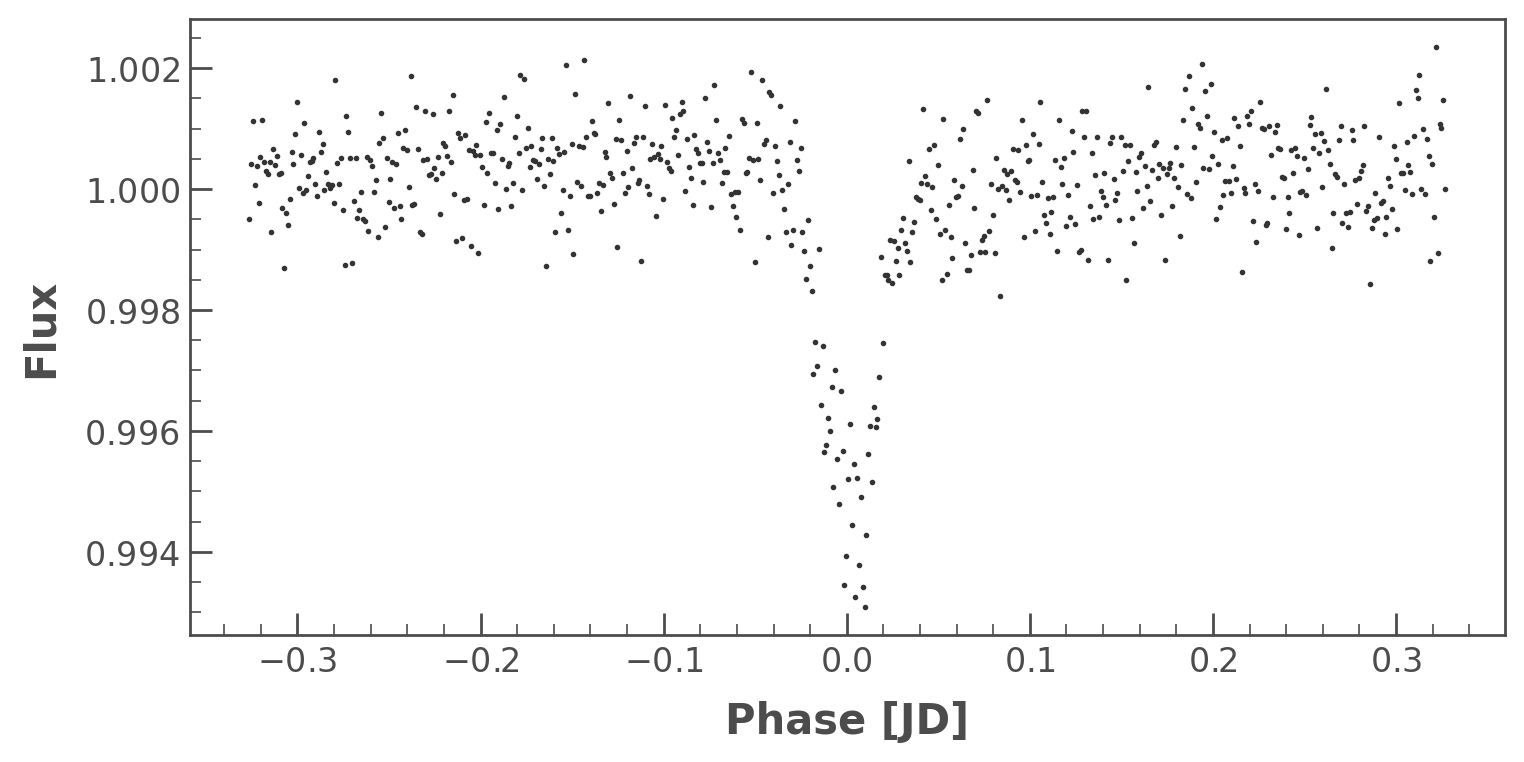

In [122]:
median_lc = k1255_lc_folded.bin(time_bin_size=0.001, aggregate_func=np.nanmedian)
median_lc.scatter()

## Asymmetric Transit Model

In [361]:
def asymmetric_transit(times, t0=0.0, depth=0.008,
                       pre_dur=0.04, pre_exp=0.5,
                       post_dur=0.04, post_exp=0.5):
    times = tt.as_tensor(times)
    flux = tt.ones_like(times)
    pre_transit = tt.and_((times > (t0 - pre_dur)), (times < t0))
    flux = tt.inc_subtensor(flux[pre_transit], (depth * pow(-(times[pre_transit] - t0)/pre_dur, pre_exp) - depth))
    post_transit = tt.and_((times > t0), (times < (t0 + post_dur)))
    flux = tt.inc_subtensor(flux[post_transit], (depth * pow((times[post_transit] - t0)/post_dur, post_exp) - depth))
    return flux

# plot_with_model(t0=0.005, depth=0.007, pre_dur=0.035, pre_exp=0.65, post_dur=0.04, post_exp=0.5)

### Model demonstration

In [201]:
from ipywidgets import interactive, widgets

In [363]:
def plot_with_model(t0=0.0, depth=0.006, pre_dur=0.04, pre_exp=0.5,
                    post_dur=0.04,post_exp=0.5):
    transit_model = asymmetric_transit(median_lc.time.value, t0=t0, depth=depth,
                                       pre_dur=pre_dur, pre_exp=pre_exp,
                                       post_dur=post_dur, post_exp=post_exp).eval()
    ax = median_lc.scatter()
    ax.plot(median_lc.time.value, transit_model, 'r-')
    ax.set_xlim(-0.15, 0.15)
    plt.show()

In [364]:
t0_widget = widgets.FloatSlider(min=-0.1, max=0.1, step=0.001, value=0.0,
                                readout_format='.3f')
depth_widget = widgets.FloatSlider(min=0.0, max=0.01, step=0.001, value=0.006,
                                   readout_format='.3f')
pre_dur_widget=widgets.FloatSlider(min=0.0, max=0.1, step=0.005, value=0.04, readout_format='.3f')
post_dur_widget=widgets.FloatSlider(min=0.0, max=0.1, step=0.005, value=0.04, readout_format='.3f')

interactive_plot = interactive(plot_with_model,
                               t0=t0_widget,
                               depth=depth_widget,
                               pre_dur=pre_dur_widget,
                               post_dur=post_dur_widget,
                               pre_exp=(0.0, 1.5, 0.05),
                               post_exp=(0.0, 1.5, 0.05))
output = interactive_plot.children[-2:]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='t0', max=0.1, min=-0.1, readout_format='.3f', step=0…

## Fit to model

### Asymmetric model fit with PyMC3

In [368]:
model = pm.Model()

with model:
    times = tt._shared(median_lc.time.value)
    t0 = pm.Uniform("t0", lower=-0.1, upper=0.1)
    depth = pm.Uniform("depth", lower=0.002, upper=0.010)
    pre_dur = pm.Uniform("pre_dur", lower=0.01, upper=0.1)
    post_dur = pm.Uniform("post_dur", lower=0.01, upper=0.1)
    pre_exp = pm.Uniform("pre_exp", lower=0.0, upper=2.0, testval=0.5)
    post_exp = pm.Uniform("post_exp", lower=0.0, upper=2.0, testval=0.5)
    
    Y_obs = pm.Normal("Y_obs", mu=asymmetric_transit(times, t0, depth, pre_dur, pre_exp, post_dur, post_exp),
                      sd=median_lc.flux_err.value, observed=median_lc.flux.value)
    

{'t0_interval__': array(0.22530189),
 'depth_interval__': array(-0.03594467),
 'pre_dur_interval__': array(-0.8302103),
 'post_dur_interval__': array(-1.43510817),
 'pre_exp_interval__': array(1.85194024),
 'post_exp_interval__': array(-1.32871672),
 't0': array(0.01121768),
 'depth': array(0.00592812),
 'pre_dur': array(0.03732405),
 'post_dur': array(0.02730736),
 'pre_exp': array(1.7287095),
 'post_exp': array(0.41874343)}

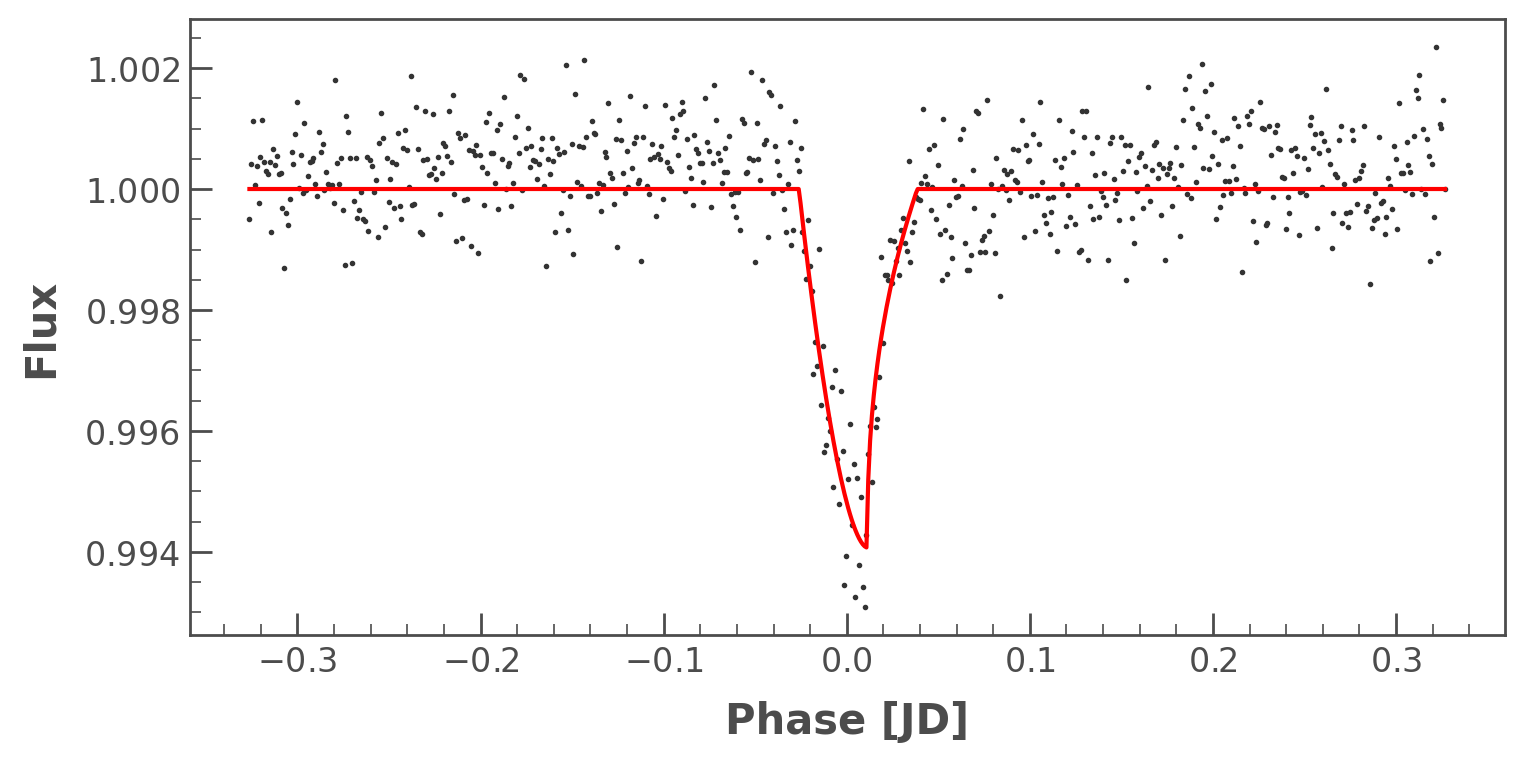

In [369]:
with model:
    map_params = pm.find_MAP()

display(map_params)
ax = median_lc.scatter()
ax.plot(times.eval(), asymmetric_transit(times, t0=map_params['t0'], depth=map_params['depth'],
                                         pre_dur=map_params['pre_dur'], post_dur=map_params['post_dur'],
                                         pre_exp=map_params['pre_exp'], post_exp=map_params['post_exp']).eval(), 'r-')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [post_exp, pre_exp, post_dur, pre_dur, depth, t0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


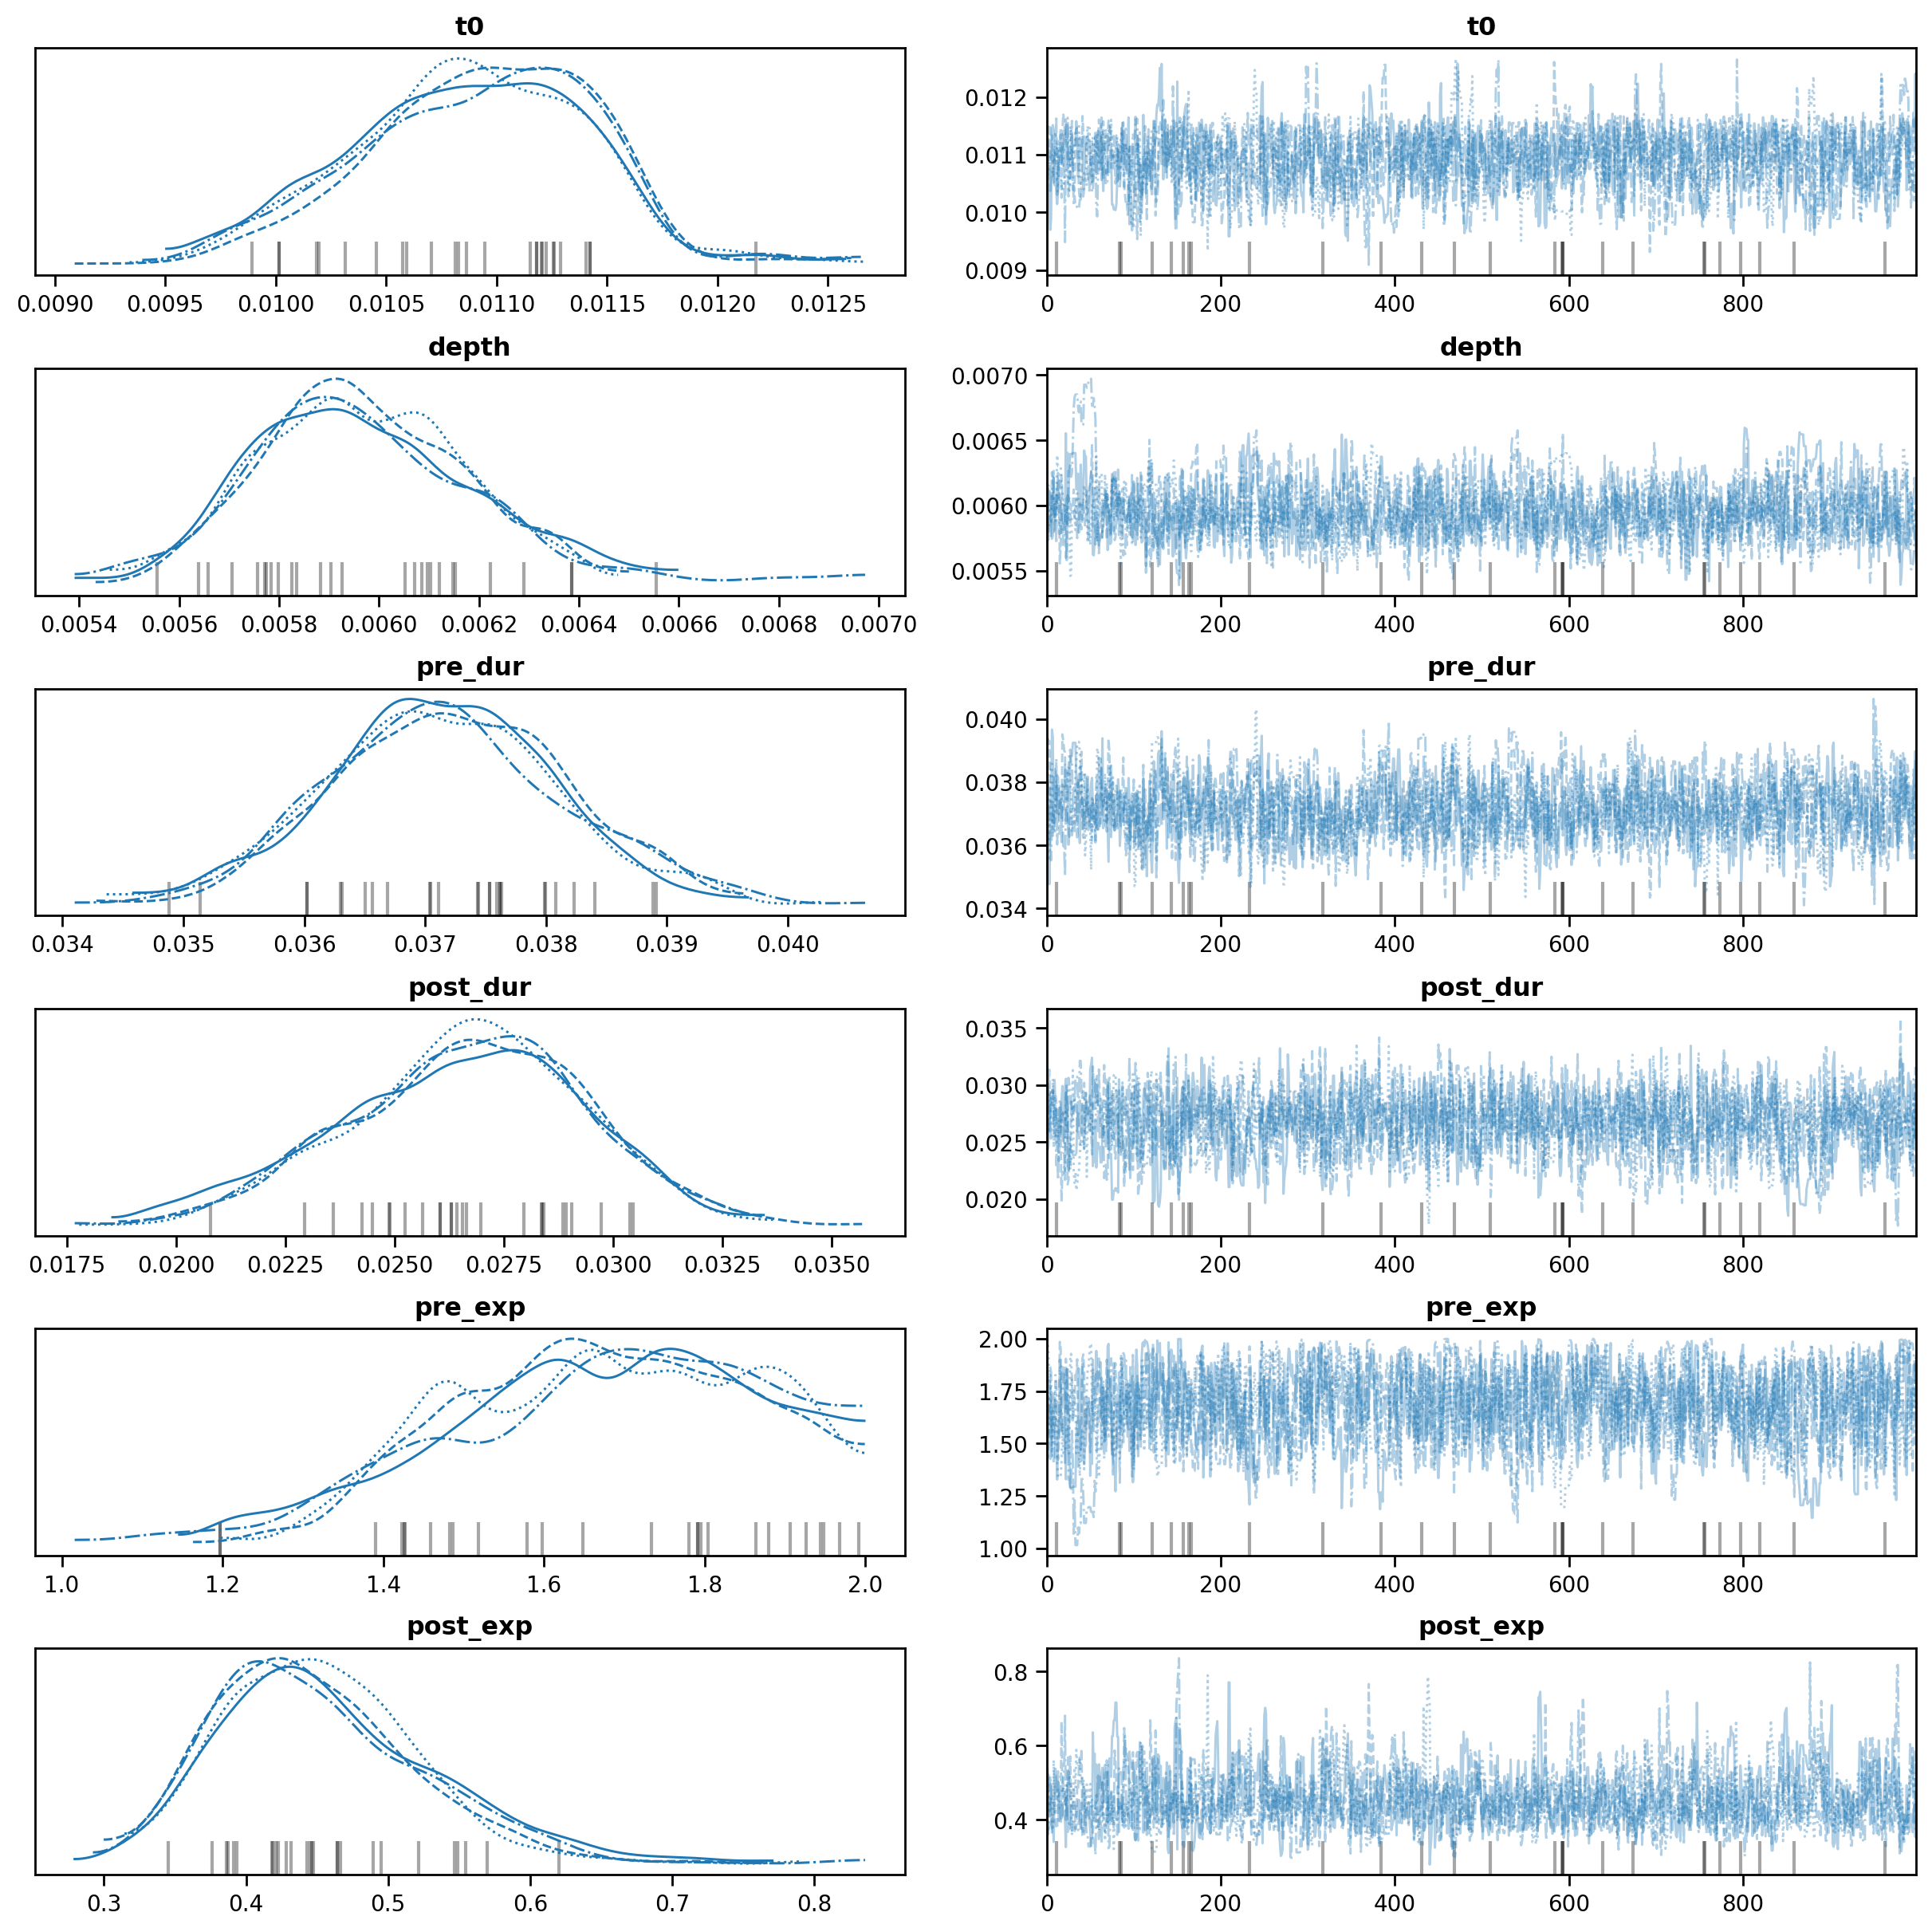

In [372]:
with model:
    trace = pm.sample(draws=1000, tune=2000, chains=4, cores=4)
    pm.traceplot(trace)

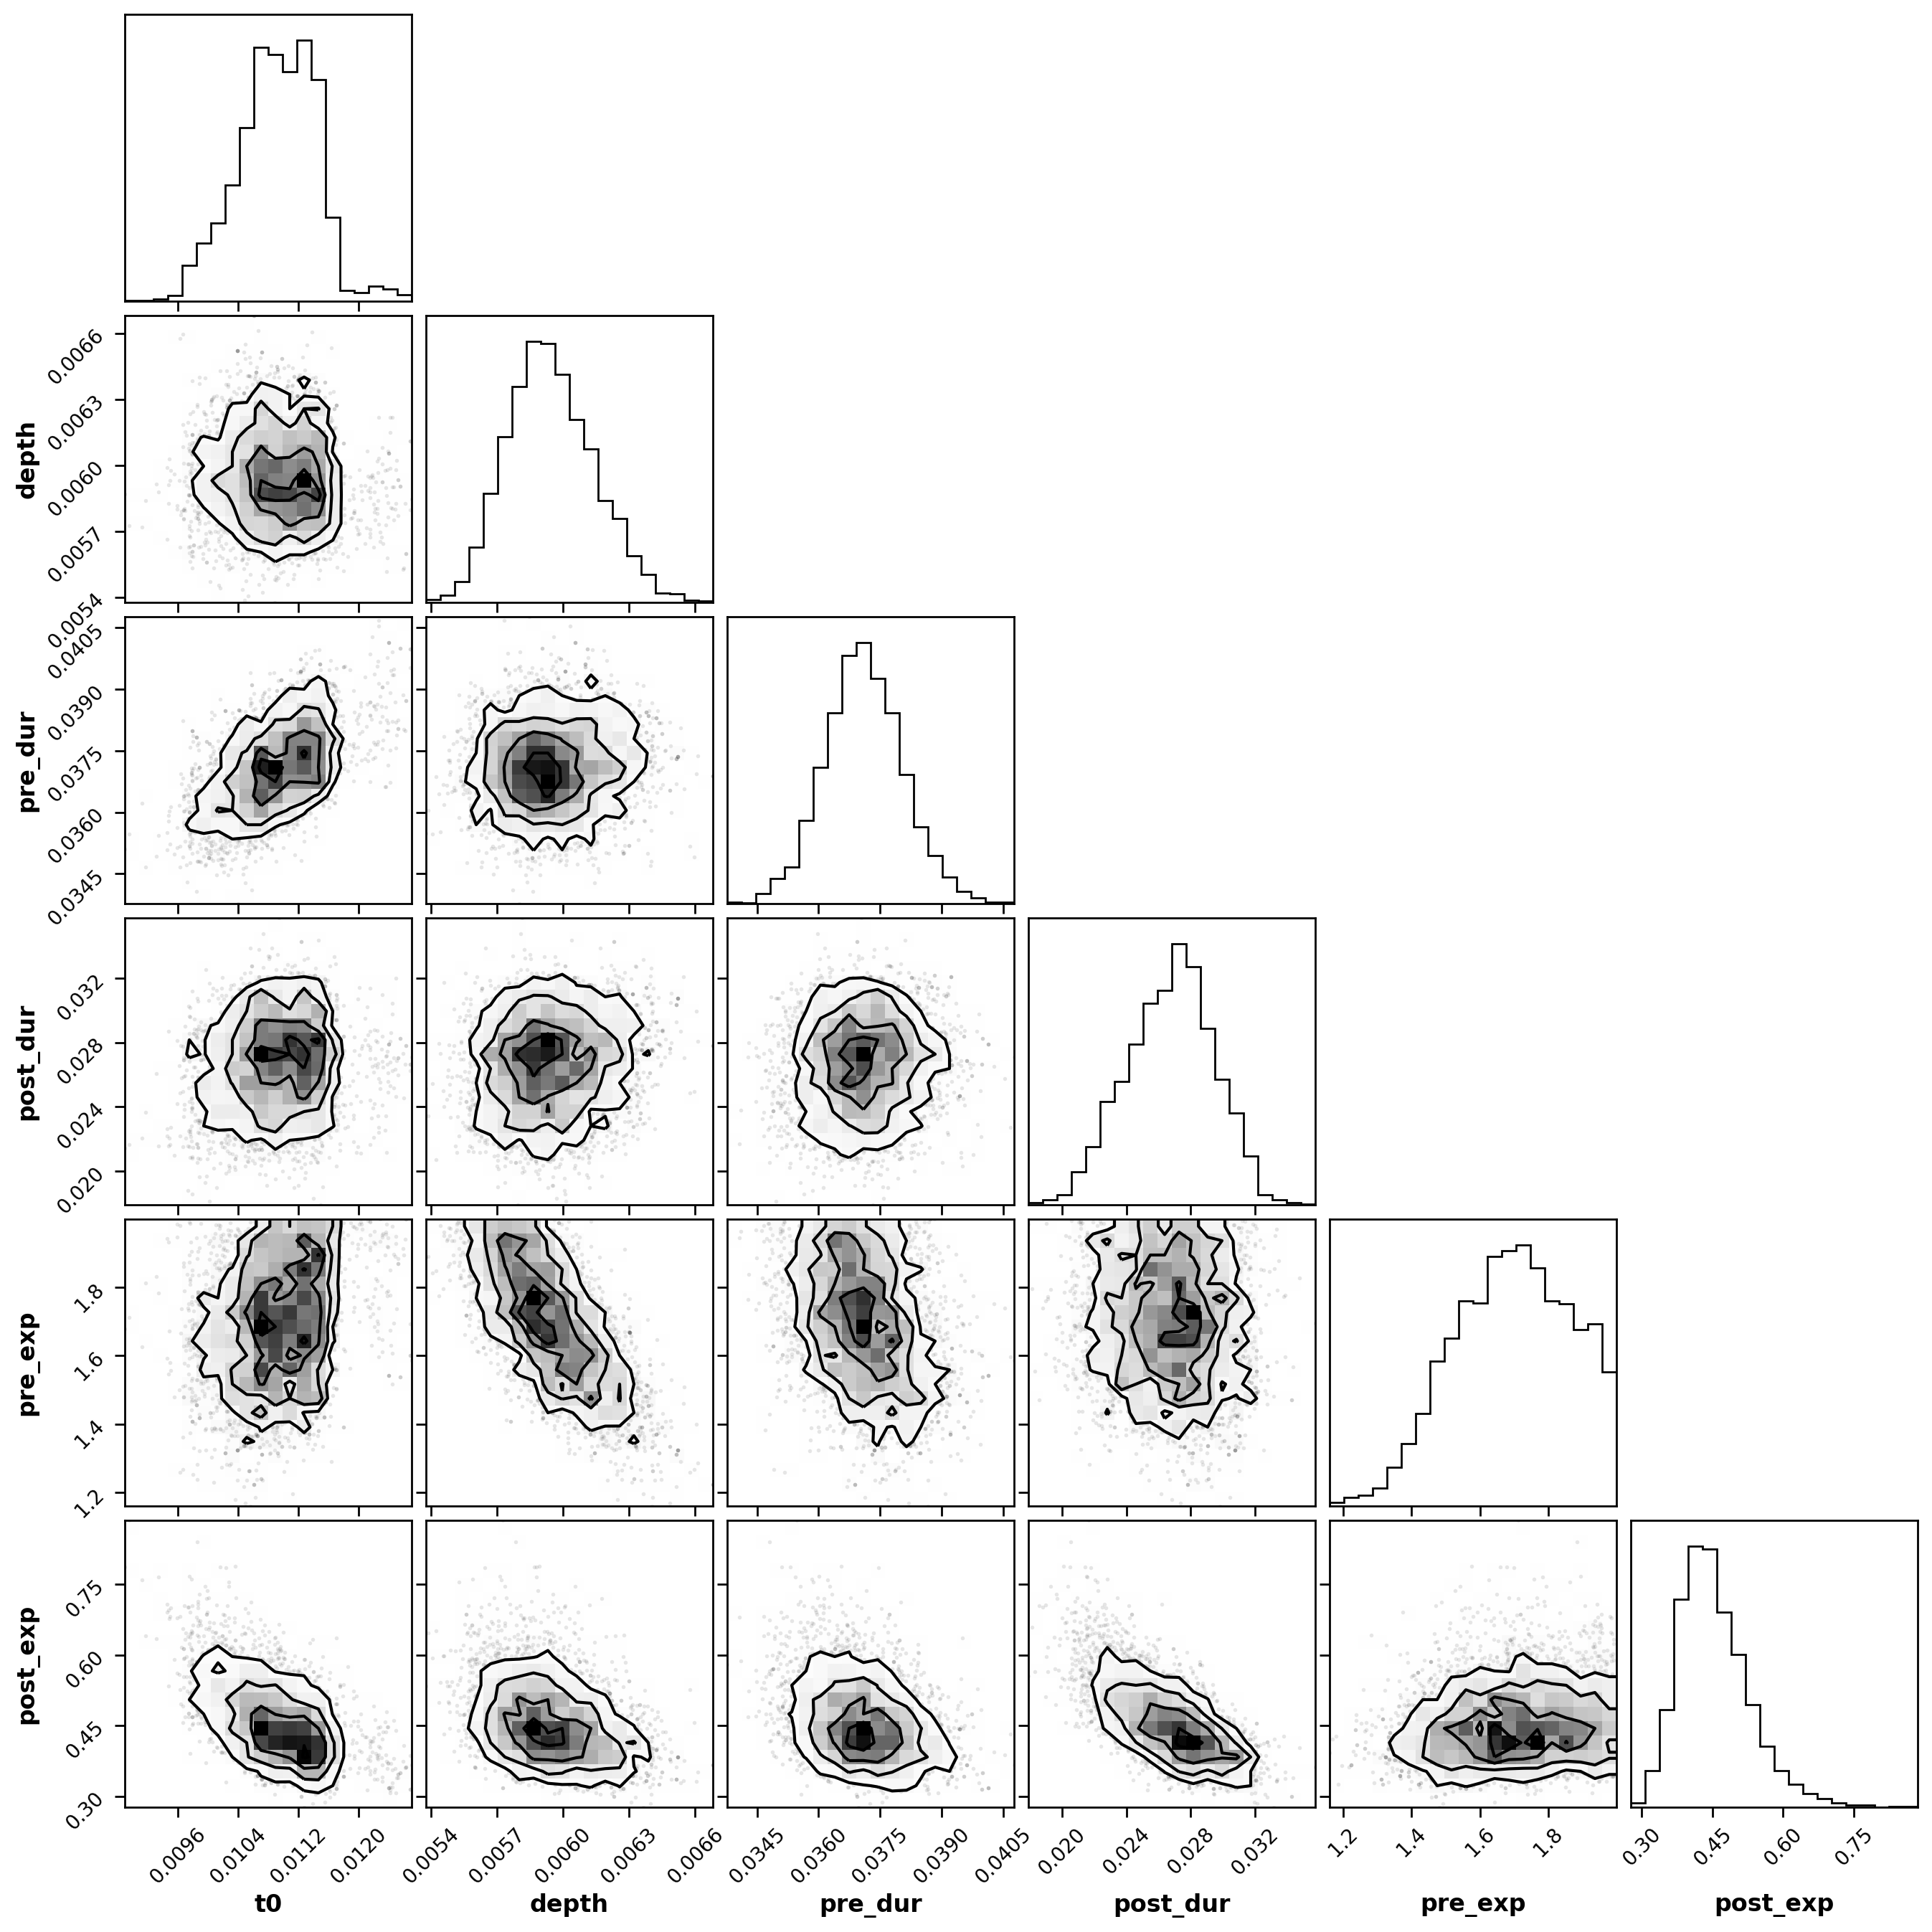

In [371]:
with model:
    samples = pm.trace_to_dataframe(trace, varnames=['t0', 'depth', 'pre_dur', 'post_dur', 'pre_exp', 'post_exp'])
    _ = corner.corner(samples)

### Full asymmetric transit

In [524]:
lc_times = k1255_lc_short.time.value
lc_t0 = 1198
lc_P = 0.6535538

flux = k1255_lc_short.flux.value
phase        = (lc_times - lc_t0) / lc_P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
trns_min = trns_numbers.min()
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

In [511]:
# pre-compute number of transits
def full_asymmetric_transit(times, depths, t0=0.0,
                            ingress_dur=0.1, ingress_exp=0.5,
                            egress_dur=0.1, egress_exp=0.5):
    times = tt.as_tensor(times)
    flux = tt.ones_like(times)
    for i in range(len(trns_numbers)):
        tr_num = trns_min + i
        t_trans = lc_t0 + t0 + tr_num * period

        ingress = tt.and_(times > (t_trans - ingress_dur), times < t_trans)
        flux = tt.inc_subtensor(flux[ingress], (depths[i] * pow(-(times[ingress] - t_trans)/ingress_dur, ingress_exp) - depths[i]))
        egress = tt.and_(times > t_trans, times < (t_trans + egress_dur))
        flux = tt.inc_subtensor(flux[egress], (depths[i] * pow((times[egress] - t_trans)/egress_dur, egress_exp) - depths[i]))

    return flux

# plot_with_model(t0=0.005, depth=0.007, pre_dur=0.035, pre_exp=0.65, post_dur=0.04, post_exp=0.5)

In [512]:
uniform_depths = np.ones(len(trns_numbers)) * 0.005

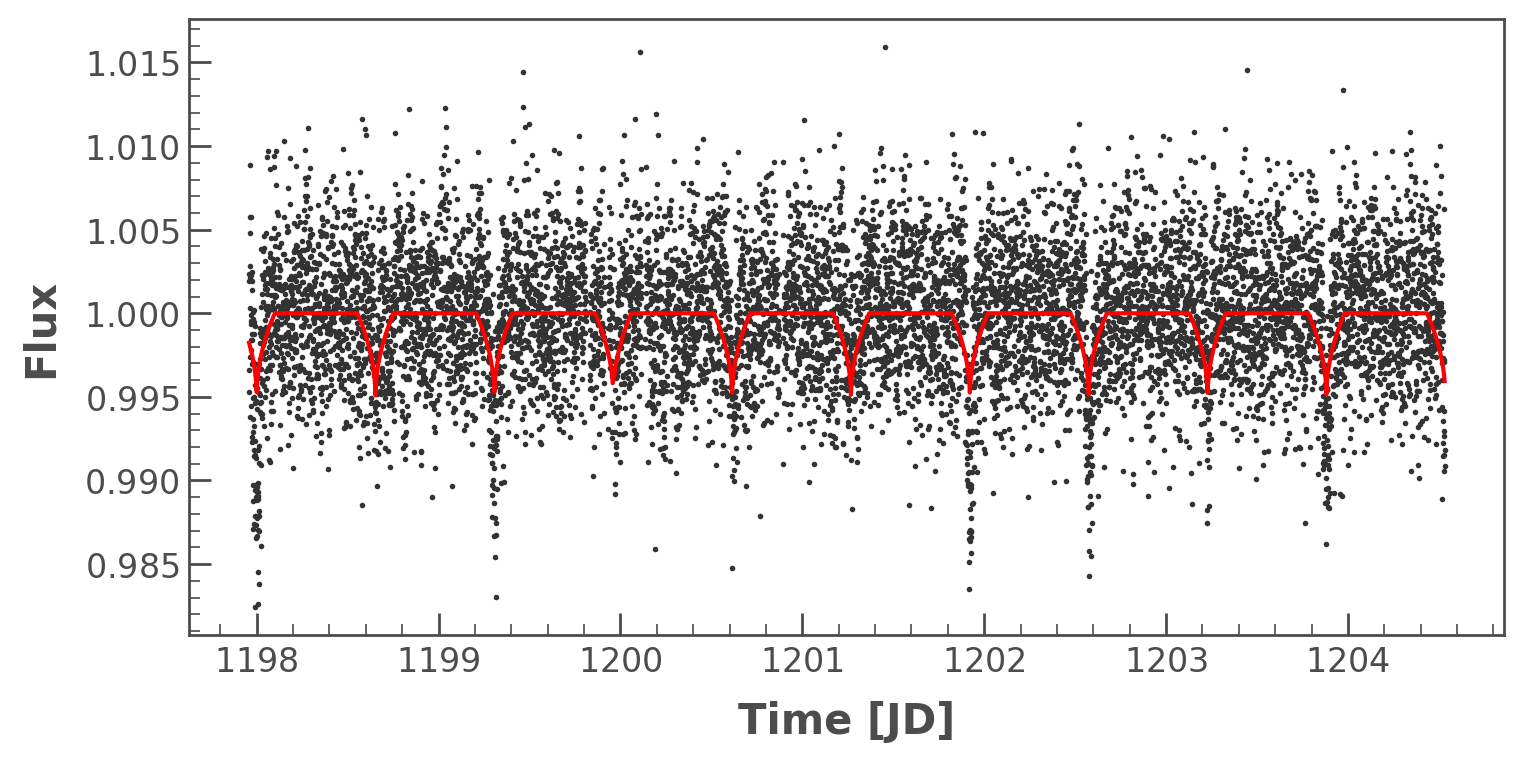

In [513]:
ax = k1255_lc_short.scatter()
ax.plot(lc_times, full_asymmetric_transit(lc_times, uniform_depths).eval(), 'r-')

### Fit independent depths

In [520]:
with pm.Model() as full_model:
    t0 = pm.Uniform("t0", lower=-0.1, upper=0.1)
    depths = pm.Uniform("depths", lower=0.0, upper=0.02, shape=len(trns_numbers))
    ingress_dur = pm.Uniform("ingress_dur", lower=0.01, upper=0.1)
    egress_dur = pm.Uniform("egress_dur", lower=0.01, upper=0.1)
    ingress_exp = pm.Uniform("ingress_exp", lower=0.0, upper=2.0, testval=0.5)
    egress_exp = pm.Uniform("egress_exp", lower=0.0, upper=2.0, testval=0.5)
    
    flux_obs = pm.Normal("flux_obs", mu=full_asymmetric_transit(lc_times, depths, t0=t0,
                                                                ingress_dur=ingress_dur, ingress_exp=ingress_exp,
                                                                egress_dur=egress_dur, egress_exp=egress_exp),
                          sd=k1255_lc_short.flux_err.value, observed=k1255_lc_short.flux.value)

In [521]:
with full_model:
    full_map_params = pm.find_MAP()
display(full_map_params)

INFO (theano.gof.compilelock): Refreshing lock /Users/swyee/.theano/compiledir_macOS-10.13.6-x86_64-i386-64bit-i386-3.8.5-64/lock_dir/lock


In [530]:
map_lc = full_asymmetric_transit(lc_times, full_map_params['depths'], t0=full_map_params['t0']).eval()

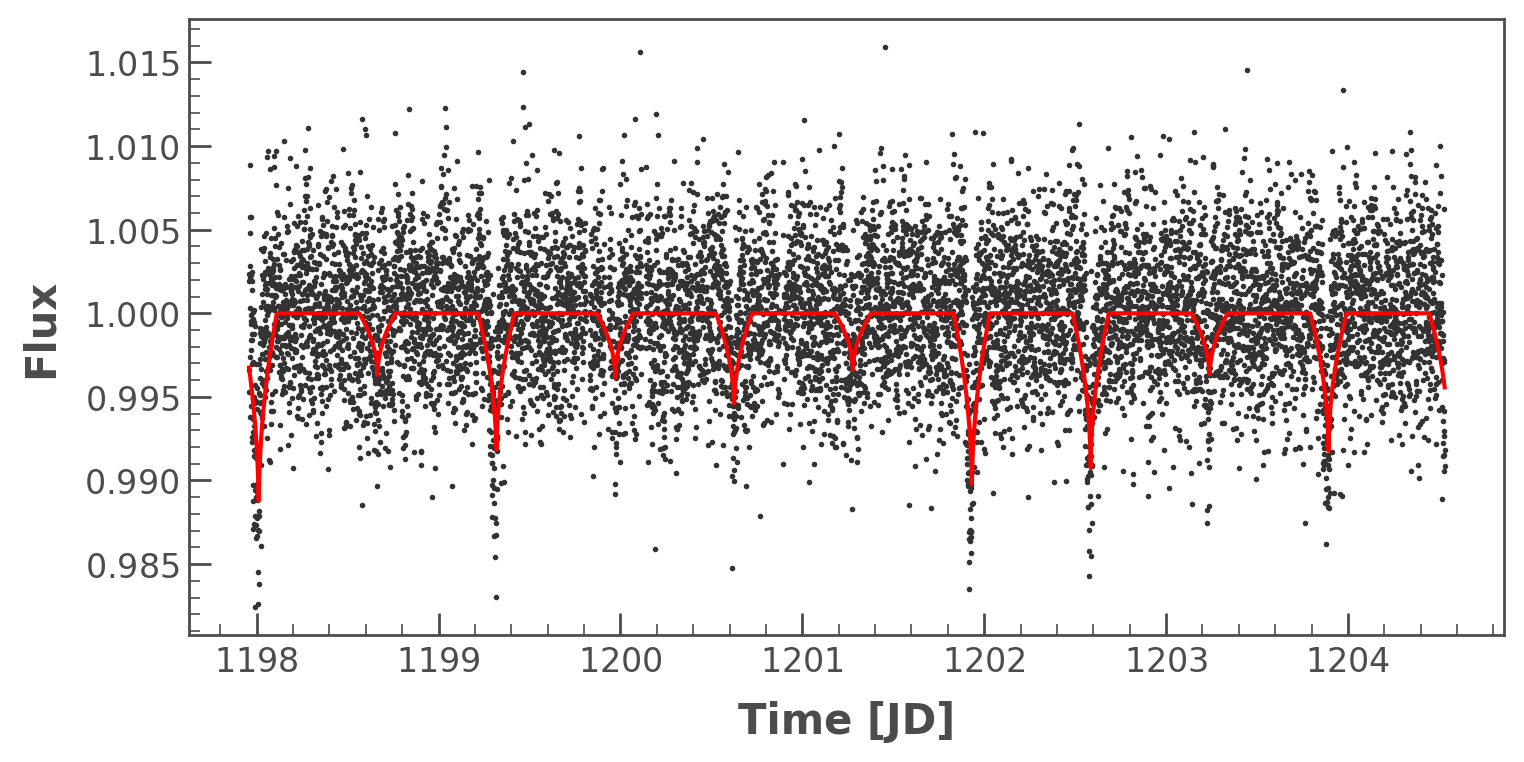

In [531]:
ax = k1255_lc_short.scatter()
ax.plot(lc_times, map_lc, 'r-')

(1201.7, 1202.1)

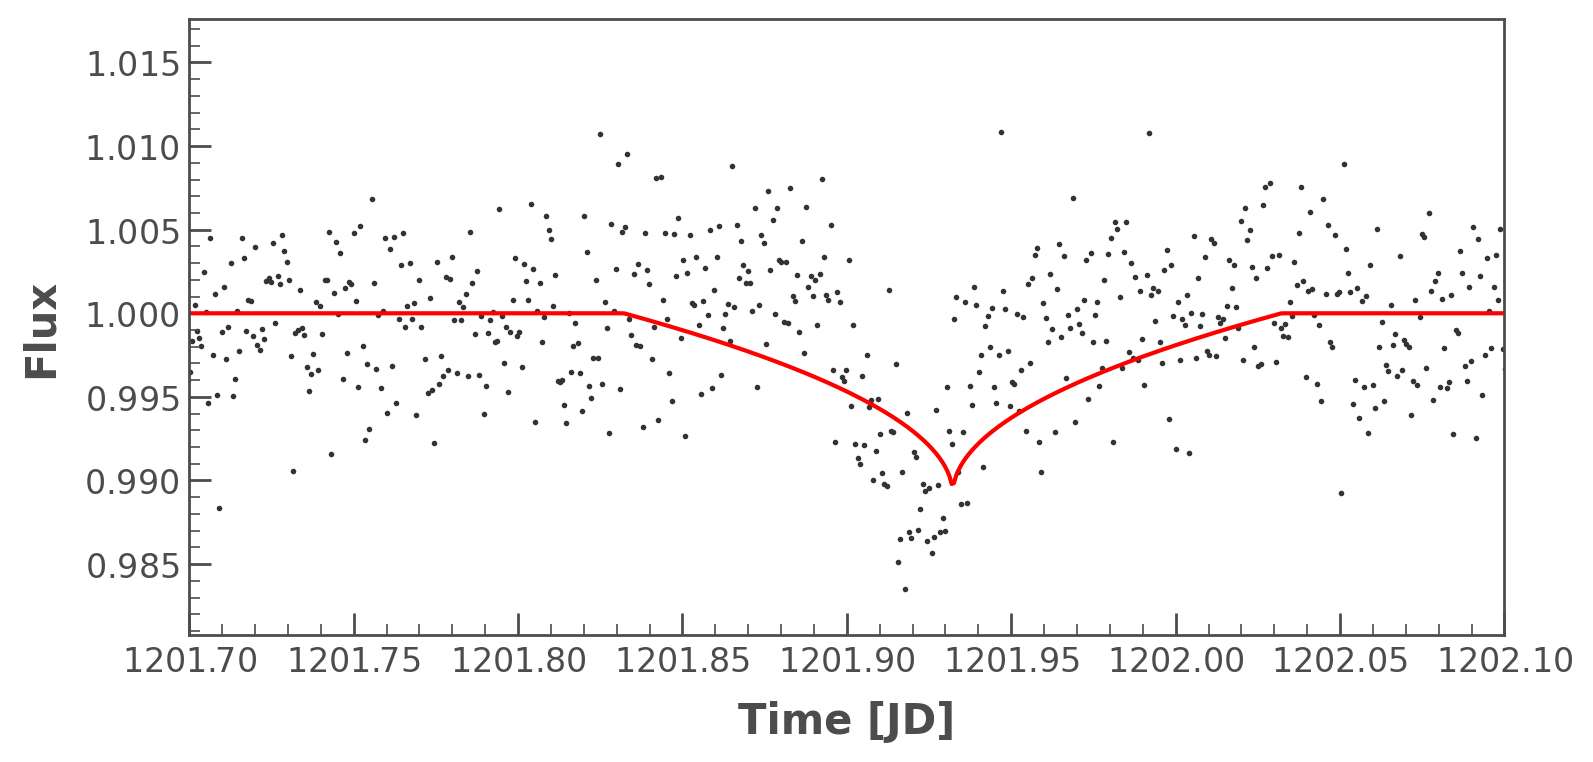

In [540]:
ax = k1255_lc_short.scatter()
ax.plot(lc_times, full_asymmetric_transit(lc_times, full_map_params['depths'], t0=full_map_params['t0']).eval(), 'r-')
ax.set_xlim(1199, 1199.4)

(0.4, 0.6)

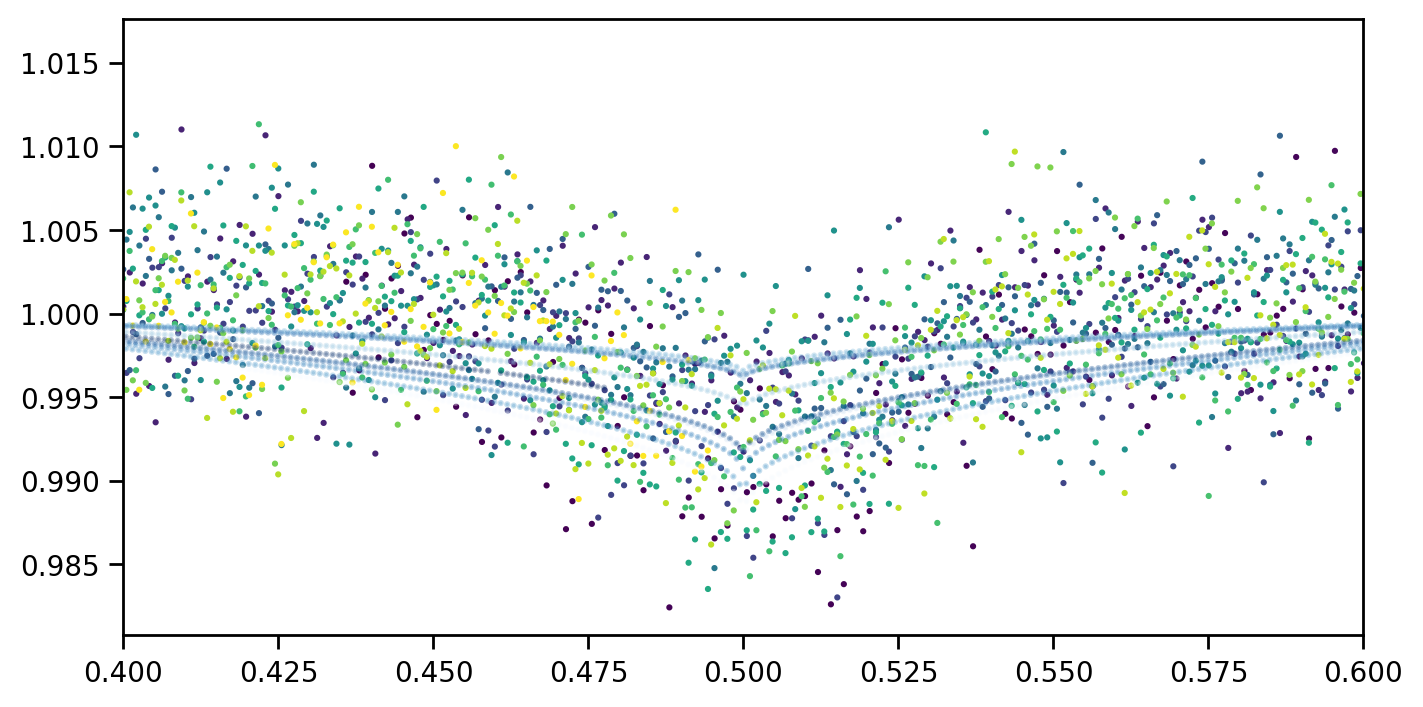

In [537]:
nphase = (lc_times - lc_t0 - full_map_params['t0']) / lc_P
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter((phase-0.5)%1, flux,c=phase-phase[0], cmap='viridis',s=1.5)
plt.scatter((nphase-0.5)%1, full_asymmetric_transit(lc_times, full_map_params['depths'], t0=full_map_params['t0']).eval(), c=nphase-nphase[0],cmap='Blues',s=1.5,alpha=0.3)
ax.set_xlim(0.4, 0.6)